# K-Nearest Neighbor Lab





In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import arff
from IPython.core.display import display

import math
import copy

from sklearn.preprocessing import LabelEncoder
import pdb

import warnings; warnings.simplefilter('ignore')

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [74]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', knn=3): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.knn = knn

    def fit(self, X, y, labels=None):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X, self.y = X, y
        return self
    
    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """

        predictions = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            instance = X[i, :]
            distances = (self.X - instance)**2

            if np.any(self.columntype):
                mask = (self.X == instance)
                nominal_columns = np.where(self.columntype == 1)
                distances[nominal_columns] = mask[nominal_columns]

            distances = np.sqrt(distances.sum(axis=1))
            predicted_class = self._predicted_class(self.y, distances)
            predictions[i] = predicted_class

        return predictions

    def _predicted_class(self, classes, distances):

        data = np.append(classes.reshape(-1, 1), distances.reshape(-1, 1), axis=1)
        data = data[data[:, 1].argsort()][:self.knn, :]

        if self.weight_type == 'inverse_distance':
            data[:, 1] = np.where(data[:, 1] != 0, 1/(data[:, 1]**2), np.inf)
        else:
            data[:, 1] = 1

        return np.bincount(data[:, 0].reshape(-1).astype(int), weights=data[:, 1].reshape(-1)).argmax()

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        return (predictions == y.reshape(-1)).mean()


In [73]:
class KNNRegressor(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', knn=3): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.knn = knn

    def fit(self, X, y, labels=None):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X, self.y = X, y
        return self
    
    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """

        predictions = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            instance = X[i, :]
            distances = (self.X - instance)**2

            if np.any(self.columntype):
                mask = (self.X == instance)
                nominal_columns = np.where(self.columntype == 1)
                distances[nominal_columns] = mask[nominal_columns]

            distances = np.sqrt(distances.sum(axis=1))
            predicted_value = self._predicted_value(self.y, distances)
            predictions[i] = predicted_value

        return predictions

    def _predicted_value(self, classes, distances):

        data = np.append(classes.reshape(-1, 1), distances.reshape(-1, 1), axis=1)
        data = data[data[:, 1].argsort()][:self.knn, :]

        if self.weight_type == 'inverse_distance':
            data[:, 1] = np.where(data[:, 1] != 0, 1/(data[:, 1]**2), np.inf)
        else:
            data[:, 1] = 1

        return np.sum(data[:, 1] * data[:, 0]) / data[:, 1].sum()

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        return ((predictions - y.reshape(-1))**2).mean()

In [75]:
def load_data(filename):
    data = arff.loadarff(filename)
    df = pd.DataFrame(data[0])

    for i in range(len(df.dtypes)):
        if df.dtypes.astype(str).iloc[i] == 'object':
            column = df.columns[i]
            df[column] = df[column] \
                            .astype(str).str \
                            .split("\'", expand=True) \
                            .iloc[:,1]
    return df

def encode_X(X1, X2):
    columns = X1.columns

    for column in columns:
        if X1[column].dtype == 'object':
            le = LabelEncoder()
            le.fit(X1[column])
            X1[column] = le.transform(X1[column])
            X2[column] = le.transform(X2[column])
   
    return X1, X2

def encode_y(y1, y2):
    name = y1.name
    le = LabelEncoder()
    le.fit(y1)
    y1 = le.transform(y1)
    y2 = le.transform(y2)
    return pd.DataFrame(y1, columns=[name]), pd.DataFrame(y2, columns=[name])

def get_column_types(df):
    c_types = df.dtypes.astype(str)
    c_types = c_types.map({'float64': 0, 'object': 1})
    return c_types.to_numpy().reshape(-1)[:-1]

def normalize(X1, X2):
    len_X1 = X1.shape[0]
    X = np.append(X1, X2, axis=0)
    feature_mins = X.min(axis=0)
    feature_maxs = X.max(axis=0)

    X = (X-feature_mins) / (feature_maxs - feature_mins)
    
    return X[:len_X1, :], X[len_X1:, :]

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_prediction.csv)

- Using inverse weighted distancing = roughly [74.39%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_prediction.csv)


In [76]:
# Load glass data
glass_trainDF = load_data('datasets/glass_train.arff')
glass_testDF = load_data('datasets/glass_test.arff')

# Get column types
column_types = get_column_types(glass_trainDF)

glass_X_trainDF, glass_y_trainDF = glass_trainDF.iloc[:, :-1], glass_trainDF.iloc[:, -1]
glass_X_testDF, glass_y_testDF = glass_testDF.iloc[:, :-1], glass_testDF.iloc[:, -1]

glass_X_train, glass_X_test = encode_X(glass_X_trainDF, glass_X_testDF)
glass_y_train, glass_y_test = encode_y(glass_y_trainDF, glass_y_testDF)

X_train = glass_X_train.to_numpy()
X_test = glass_X_test.to_numpy()
y_train = glass_y_train.to_numpy()
y_test = glass_y_test.to_numpy()

# Train on training set
glass_knn_d_weighting = KNNClassifier(columntype=column_types)
glass_knn_nd_weighting = KNNClassifier(columntype=column_types, weight_type=None)
glass_knn_d_weighting.fit(X_train, y_train)
glass_knn_nd_weighting.fit(X_train, y_train)

# Predict on test set
glass_score_d_weighting = glass_knn_d_weighting.score(X_test, y_test)
glass_score_nd_weighting = glass_knn_nd_weighting.score(X_test, y_test)
print("Score with inverted distance weighting: %.4f" % glass_score_d_weighting)
print("Score with no inverted distance weighting: %.4f" % glass_score_nd_weighting)

Score with inverted distance weighting: 0.7439
Score with no inverted distance weighting: 0.6829


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [77]:
# Load diabetes data
diabetes_trainDF = load_data('datasets/diabetes_train.arff')
diabetes_testDF = load_data('datasets/diabetes_test.arff')

# Get column types
column_types = get_column_types(diabetes_trainDF)[:-1]

diabetes_X_trainDF, diabetes_y_trainDF = diabetes_trainDF.iloc[:, :-1], diabetes_trainDF.iloc[:, -1]
diabetes_X_testDF, diabetes_y_testDF = diabetes_testDF.iloc[:, :-1], diabetes_testDF.iloc[:, -1]

diabetes_X_train, diabetes_X_test = encode_X(diabetes_X_trainDF, diabetes_X_testDF)
diabetes_y_train, diabetes_y_test = encode_y(diabetes_y_trainDF, diabetes_y_testDF)

# Train on training set
X_train = diabetes_X_train.to_numpy()
X_test = diabetes_X_test.to_numpy()
y_train = diabetes_y_train.to_numpy()
y_test = diabetes_y_test.to_numpy()

diabetes_knn = KNNClassifier(columntype=column_types)
diabetes_knn.fit(X_train, y_train)

# Predict on test set
score = diabetes_knn.score(X_test, y_test)
print("Evaluation dataset KNN accuracy: %.3f" % score)


Evaluation dataset KNN accuracy: 0.891


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [62]:
# Load diabetes data
magic_telescope_trainDF = load_data('datasets/magic_telescope_train.arff')
magic_telescope_testDF = load_data('datasets/magic_telescope_test.arff')

display(magic_telescope_trainDF.head(2))
print(magic_telescope_trainDF.shape)
display(magic_telescope_testDF.head(2))
print(magic_telescope_testDF.shape)

# Get column types
magic_telescope_column_types = get_column_types(magic_telescope_trainDF)[:-1]

# X and y splits
magic_telescope_X_trainDF, magic_telescope_y_trainDF = magic_telescope_trainDF.iloc[:, :-1], magic_telescope_trainDF.iloc[:, -1]
magic_telescope_X_testDF, magic_telescope_y_testDF = magic_telescope_testDF.iloc[:, :-1], magic_telescope_testDF.iloc[:, -1]

magic_telescope_X_train, magic_telescope_X_test = encode_X(magic_telescope_X_trainDF, magic_telescope_X_testDF)
magic_telescope_y_train, magic_telescope_y_test = encode_y(magic_telescope_y_trainDF, magic_telescope_y_testDF)

# To numpy arrays
X_telescope_train = magic_telescope_X_train.to_numpy()
X_telescope_test = magic_telescope_X_test.to_numpy()
y_telescope_train = magic_telescope_y_train.to_numpy()
y_telescope_test = magic_telescope_y_test.to_numpy()

# Normalize input features
X_telescope_train_norm, X_telescope_test_norm = normalize(X_telescope_train, X_telescope_test)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,22.7815,14.9526,2.4362,0.4982,0.2509,-14.2836,-9.3635,13.0939,3.0779,141.562,g
1,40.6756,15.5940,2.7447,0.2772,0.1449,19.6226,9.0297,7.4157,15.4260,193.234,g


(12354, 11)


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,30.5540,21.1807,2.7509,0.2715,0.1500,2.1798,-20.8938,-15.2262,2.2982,197.390,g
1,59.2444,10.4634,2.8051,0.4019,0.1971,49.4360,25.1317,7.0386,71.0828,48.129,h


(6666, 11)


In [92]:
magic_telescope_knn = KNNClassifier(columntype=magic_telescope_column_types, weight_type=None)
magic_telescope_knn.fit(X_telescope_train, y_telescope_train)

# Predict on test set
score = magic_telescope_knn.score(X_telescope_test, y_telescope_test)
print("Magic telescope dataset KNN accuracy: %.3f" % score)

Magic telescope dataset KNN accuracy: 0.808


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [93]:
# Train/Predict with normalization
magic_telescope_knn.fit(X_telescope_train_norm, y_telescope_train)

# Predict on test set
score = magic_telescope_knn.score(X_telescope_test_norm, y_telescope_test)
print("Magic telescope dataset KNN accuracy: %.3f" % score)

Magic telescope dataset KNN accuracy: 0.830


*Discuss the accuracy results of using normalized data vs. unnormalized data*

The unnormalized accuracy for the magic telescope dataset was 80.8% while the normalized accuracy on the data was 83%. This 2.2% jump in accuracy seems very significant considering there are 12354 training examples and 6666 testing examples. Normalizing may not always provide better results but in this case it does.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [107]:
# Train/Predict with normalization using k=1,3,...,15
magic_nw_knns = np.arange(1, 16, 2)
magic_nw_accuracies = []
for knn in magic_nw_knns:
    print("Magic Telescore KNN %d" % knn)
    knnc = KNNClassifier(columntype=magic_telescope_column_types, knn=knn, weight_type=None)
    magic_nw_accuracies.append(knnc.fit(X_telescope_train_norm, y_telescope_train) \
        .score(X_telescope_test_norm, y_telescope_test))

Magic Telescore KNN 1
Magic Telescore KNN 3
Magic Telescore KNN 5
Magic Telescore KNN 7
Magic Telescore KNN 9
Magic Telescore KNN 11
Magic Telescore KNN 13
Magic Telescore KNN 15


Text(0.5, 1.0, 'Magic Telescope Accuracy vs K-Nearest Neighbors')

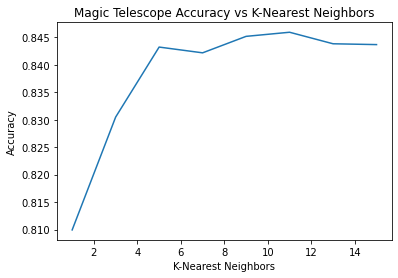

In [108]:
# Graph classification accuracy over k
plt.plot(magic_nw_knns, magic_nw_accuracies)
plt.xlabel('K-Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Magic Telescope Accuracy vs K-Nearest Neighbors')

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


In [109]:
# Load housing price prediction data
housing_trainDF = load_data('datasets/housing_train.arff')
housing_testDF = load_data('datasets/housing_test.arff')

display(housing_trainDF.head(2))
print(housing_trainDF.shape)
display(housing_testDF.head(2))
print(housing_testDF.shape)

# Get column types
housing_column_types = get_column_types(housing_trainDF)[:-1]

# X and y splits
housing_X_trainDF, housing_y_trainDF = housing_trainDF.iloc[:, :-1], housing_trainDF.iloc[:, -1]
housing_X_testDF, housing_y_testDF = housing_testDF.iloc[:, :-1], housing_testDF.iloc[:, -1]

housing_X_train, housing_X_test = encode_X(housing_X_trainDF, housing_X_testDF)
housing_y_train, housing_y_test = housing_y_trainDF, housing_y_testDF

# To numpy arrays
X_housing_train = housing_X_train.to_numpy()
X_housing_test = housing_X_test.to_numpy()
y_housing_train = housing_y_train.to_numpy()
y_housing_test = housing_y_test.to_numpy()

# Normalize input features
X_housing_train_norm, X_housing_test_norm = normalize(X_housing_train, X_housing_test)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


(455, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0


(51, 14)


In [110]:
# Train/Predict using k=1,3,...,15
house_nw_knns = np.arange(1, 16, 2)
house_nw_mses = []
for knn in house_nw_knns:
    print("Housing KNN %d" % knn)
    knnr = KNNRegressor(columntype=housing_column_types, knn=knn, weight_type=None)
    house_nw_mses.append(knnr.fit(X_housing_train_norm, y_housing_train) \
        .score(X_housing_test_norm, y_housing_test))

Housing KNN 1
Housing KNN 3
Housing KNN 5
Housing KNN 7
Housing KNN 9
Housing KNN 11
Housing KNN 13
Housing KNN 15


Text(0.5, 1.0, 'No Inverse Weighting Housing MSE vs K-Nearest Neighbors')

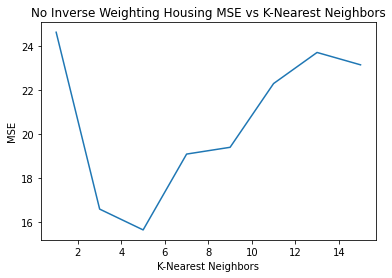

In [111]:
# Graph MSE over k
plt.plot(house_nw_knns, house_nw_mses)
plt.xlabel('K-Nearest Neighbors')
plt.ylabel('MSE')
plt.title('No Inverse Weighting Housing MSE vs K-Nearest Neighbors')

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

In [112]:
# Train/Predict magic telescope using distance-weighted voting
magic_w_knns = np.arange(1, 16, 2)
magic_w_accuracies = []
for knn in magic_w_knns:
    print("Magic Telescore KNN %d" % knn)
    knnc = KNNClassifier(columntype=magic_telescope_column_types, knn=knn)
    magic_w_accuracies.append(knnc.fit(X_telescope_train_norm, y_telescope_train) \
        .score(X_telescope_test_norm, y_telescope_test))

Magic Telescore KNN 1
Magic Telescore KNN 3
Magic Telescore KNN 5
Magic Telescore KNN 7
Magic Telescore KNN 9
Magic Telescore KNN 11
Magic Telescore KNN 13
Magic Telescore KNN 15


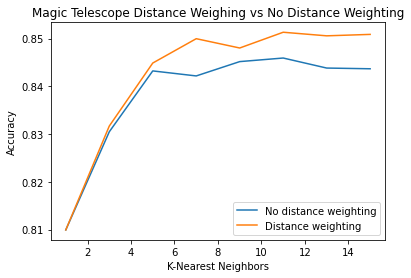

In [118]:
# Graph no distance weighting and distance weighting comp for magic telescope
plt.plot(magic_nw_knns, magic_nw_accuracies, label='No distance weighting')
plt.plot(magic_w_knns, magic_w_accuracies, label='Distance weighting')
plt.xlabel('K-Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Magic Telescope Distance Weighing vs No Distance Weighting')
plt.legend()

## 4.2 Housing Dataset

In [114]:
# Train/Predict housing using distance-weighted voting
house_w_knns = np.arange(1, 16, 2)
house_w_mses = []
for knn in house_w_knns:
    print("Housing KNN %d" % knn)
    knnr = KNNRegressor(columntype=housing_column_types, knn=knn)
    house_w_mses.append(knnr.fit(X_housing_train_norm, y_housing_train) \
        .score(X_housing_test_norm, y_housing_test))

Housing KNN 1
Housing KNN 3
Housing KNN 5
Housing KNN 7
Housing KNN 9
Housing KNN 11
Housing KNN 13
Housing KNN 15


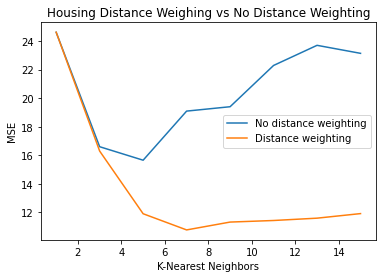

In [119]:
# Graph no distance weighting and distance weighting comp for housing
plt.plot(house_nw_knns, house_nw_mses, label='No distance weighting')
plt.plot(house_w_knns, house_w_mses, label='Distance weighting')
plt.xlabel('K-Nearest Neighbors')
plt.ylabel('MSE')
plt.title('Housing Distance Weighing vs No Distance Weighting')
plt.legend()

*Discuss your results*

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [124]:
from sklearn.model_selection import train_test_split

# Load dataset and split into train/test sets
creditDF = load_data('datasets/credit_approval.arff')
creditDF[creditDF.isna().any(axis=1)]



# Train/Predict credit-approval


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
71,b,34.83,4.000,u,g,d,bb,12.500,t,f,0.0,t,g,NaN,0.0,-
83,a,NaN,3.500,u,g,d,v,3.000,t,f,0.0,t,g,300.0,0.0,-
86,b,NaN,0.375,u,g,d,v,0.875,t,f,0.0,t,s,928.0,0.0,-
92,b,NaN,5.000,y,p,aa,v,8.500,t,f,0.0,f,g,0.0,0.0,-
97,b,NaN,0.500,u,g,c,bb,0.835,t,f,0.0,t,s,320.0,0.0,-
202,b,24.83,2.750,u,g,c,v,2.250,t,t,6.0,f,g,NaN,600.0,+
206,a,71.58,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,+
243,a,18.75,7.500,u,g,q,v,2.710,t,t,5.0,f,g,NaN,26726.0,+
254,b,NaN,0.625,u,g,k,v,0.250,f,f,0.0,f,g,380.0,2010.0,-
270,b,37.58,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,+


*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [ ]:
# Train/Predict magic telescope using scikit's KNN

# Train/Predict housing using scikit's KNN


*Report your comparison*

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
